
```
# Mortgage Credit Risk Modeling - Notebook 05: Model Development

**Course**: Advanced Econometrics and Financial Risk Management  
**Assignment**: Capstone Project - Credit Risk Modeling  
**Date**: March 2025  
**Author**: Vaness Quintero

---

## Learning Objectives


1. **Implement Industry-Standard Credit Risk Models**: Develop and compare logistic regression, regularized regression, and tree-based models following Federal Reserve model risk management guidelines

2. **Address Multicollinearity in Financial Data**: Apply regularization techniques (Ridge, Lasso, Elastic Net) to handle correlated risk factors commonly found in mortgage portfolios

3. **Handle Class Imbalance in Default Modeling**: Implement sampling techniques and cost-sensitive learning approaches to address low default rate scenarios typical in post-crisis mortgage portfolios

4. **Apply Credit Risk Performance Metrics**: Evaluate models using industry-standard measures including AUC, Gini coefficient, KS statistic, and Population Stability Index (PSI)

5. **Conduct Model Validation and Interpretation**: Perform out-of-sample testing, feature importance analysis, and model interpretability assessment for regulatory review

6. **Implement Ensemble Methods**: Develop and validate ensemble models (Random Forest, Gradient Boosting) that are widely used by major financial institutions for credit decisioning

---

## Industry Context

This notebook implements credit risk modeling methodologies used by major U.S. financial institutions for:

**Regulatory Compliance:**
- **Basel III IRB Models**: Internal Ratings-Based approach for regulatory capital
- **CCAR Stress Testing**: Federal Reserve Comprehensive Capital Analysis and Review
- **CECL Implementation**: Current Expected Credit Loss accounting standard
- **Model Risk Management**: Following SR 11-7 guidance on model development and validation

**Business Applications:**
- **Credit Decisioning**: Automated underwriting and loan approval processes
- **Risk-Based Pricing**: Interest rate setting based on predicted default probability
- **Portfolio Management**: Credit limit setting and exposure monitoring
- **Early Warning Systems**: Identifying deteriorating credits for proactive management

**Technical Approach:**
Following industry best practices, we implement multiple modeling approaches to address the multicollinearity and class imbalance challenges identified in our exploratory analysis. The methodology aligns with practices at major financal institutions
---
```


In [1]:

# First, let's install XGBoost
!pip install xgboost

# Then let's verify all your imports again
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
import os

# Statistical and econometric libraries
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Model evaluation libraries
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, 
    precision_recall_curve, average_precision_score, brier_score_loss,
    log_loss, accuracy_score, precision_score, recall_score, f1_score
)

# Class imbalance handling
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Advanced models - now with proper error handling
try:
    import xgboost as xgb
    print(f"XGBoost version {xgb.__version__} successfully imported")
except ImportError as e:
    print(f"XGBoost import error: {e}")
    print("Installing XGBoost...")
    !pip install xgboost
    try:
        import xgboost as xgb
        print(f"XGBoost version {xgb.__version__} successfully installed and imported")
    except ImportError as e2:
        print(f"XGBoost installation failed: {e2}")
        print("Using sklearn alternatives")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Model development libraries imported successfully")
print(f"Analysis started")

XGBoost version 3.0.2 successfully imported
Model development libraries imported successfully
Analysis started


In [2]:


# Load preprocessed datasets and define modeling configuration
DATA_PATHS = {
    'train_data': '../data/processed/train_data.csv',
    'validation_data': '../data/processed/validation_data.csv',
    'test_data': '../data/processed/test_data.csv',
    'model_save_path': '../models/saved_models/',
    'results_path': '../results/tables/'
}

# Ensure directories exist
os.makedirs(DATA_PATHS['model_save_path'], exist_ok=True)
os.makedirs(DATA_PATHS['results_path'], exist_ok=True)

print("LOADING PREPROCESSED DATASETS")
print("=" * 50)

try:
    # Load train, validation, and test sets
    train_data = pd.read_csv(DATA_PATHS['train_data'])
    val_data = pd.read_csv(DATA_PATHS['validation_data'])
    test_data = pd.read_csv(DATA_PATHS['test_data'])
    
    print(f"Training data: {train_data.shape}")
    print(f"Validation data: {val_data.shape}")
    print(f"Test data: {test_data.shape}")
    
    # Define modeling features (post-multicollinearity analysis)
    MODELING_FEATURES = {
        'numerical': [
            'credit_score', 'annual_income', 'loan_amount', 
            'loan_to_value', 'housing_dti'
        ],
        'categorical_encoded': [
            'credit_score_band_encoded', 'ltv_category_encoded', 
            'property_value_segment_encoded', 'risk_tier_encoded'
        ],
        'binary': [
            'first_time_buyer_flag'
        ],
        'economic': [
            'origination_year', 'origination_quarter'
        ]
    }
    
    # Combine all modeling features
    ALL_FEATURES = (MODELING_FEATURES['numerical'] + 
                   MODELING_FEATURES['categorical_encoded'] + 
                   MODELING_FEATURES['binary'] + 
                   MODELING_FEATURES['economic'])
    
    TARGET = 'default_flag'
    
    print(f"\nModeling Configuration:")
    print(f"Target variable: {TARGET}")
    print(f"Total features: {len(ALL_FEATURES)}")
    print(f"Numerical features: {len(MODELING_FEATURES['numerical'])}")
    print(f"Categorical features: {len(MODELING_FEATURES['categorical_encoded'])}")
    
    # Check feature availability in datasets
    missing_features = [f for f in ALL_FEATURES if f not in train_data.columns]
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        ALL_FEATURES = [f for f in ALL_FEATURES if f in train_data.columns]
        print(f"Adjusted feature count: {len(ALL_FEATURES)}")
    
    # Prepare modeling datasets
    X_train = train_data[ALL_FEATURES]
    y_train = train_data[TARGET]
    X_val = val_data[ALL_FEATURES]
    y_val = val_data[TARGET]
    X_test = test_data[ALL_FEATURES]
    y_test = test_data[TARGET]
    
    print(f"\nDataset Summary:")
    print(f"Training: {len(X_train):,} samples, {y_train.mean():.2%} default rate")
    print(f"Validation: {len(X_val):,} samples, {y_val.mean():.2%} default rate")
    print(f"Test: {len(X_test):,} samples, {y_test.mean():.2%} default rate")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure Notebook 03 has been completed successfully")


LOADING PREPROCESSED DATASETS
Training data: (57921, 76)
Validation data: (19307, 76)
Test data: (19307, 76)

Modeling Configuration:
Target variable: default_flag
Total features: 12
Numerical features: 5
Categorical features: 4

Dataset Summary:
Training: 57,921 samples, 1.89% default rate
Validation: 19,307 samples, 1.89% default rate
Test: 19,307 samples, 1.90% default rate


In [3]:

# Baseline model development - Logistic Regression
def develop_baseline_model(X_train, y_train, X_val, y_val):
    """Develop baseline logistic regression model"""
    
    print("BASELINE MODEL DEVELOPMENT")
    print("=" * 50)
    
    # Scale features for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Basic logistic regression
    print("\n1. STANDARD LOGISTIC REGRESSION")
    print("-" * 30)
    
    baseline_lr = LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        solver='liblinear'
    )
    
    baseline_lr.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred_proba = baseline_lr.predict_proba(X_train_scaled)[:, 1]
    y_val_pred_proba = baseline_lr.predict_proba(X_val_scaled)[:, 1]
    
    # Training performance
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Overfitting check: {train_auc - val_auc:.4f}")
    
    # Class-weighted logistic regression (handle imbalance)
    print("\n2. CLASS-WEIGHTED LOGISTIC REGRESSION")
    print("-" * 30)
    
    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_train), 
        y=y_train
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    print(f"Class weights: {class_weight_dict}")
    
    weighted_lr = LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        solver='liblinear',
        class_weight='balanced'
    )
    
    weighted_lr.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred_proba_weighted = weighted_lr.predict_proba(X_train_scaled)[:, 1]
    y_val_pred_proba_weighted = weighted_lr.predict_proba(X_val_scaled)[:, 1]
    
    # Performance
    train_auc_weighted = roc_auc_score(y_train, y_train_pred_proba_weighted)
    val_auc_weighted = roc_auc_score(y_val, y_val_pred_proba_weighted)
    
    print(f"Training AUC: {train_auc_weighted:.4f}")
    print(f"Validation AUC: {val_auc_weighted:.4f}")
    print(f"Overfitting check: {train_auc_weighted - val_auc_weighted:.4f}")
    
    # Feature importance (coefficients)
    print("\n3. FEATURE IMPORTANCE (COEFFICIENTS)")
    print("-" * 30)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': weighted_lr.coef_[0],
        'abs_coefficient': np.abs(weighted_lr.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("Top 10 most important features:")
    for _, row in feature_importance.head(10).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"  {row['feature']:<25}: {row['coefficient']:>8.4f} (default risk {direction})")
    
    return {
        'baseline_model': baseline_lr,
        'weighted_model': weighted_lr,
        'scaler': scaler,
        'baseline_auc': val_auc,
        'weighted_auc': val_auc_weighted,
        'feature_importance': feature_importance
    }

# Develop baseline models
baseline_results = develop_baseline_model(X_train, y_train, X_val, y_val)

print(f"\nBaseline model development completed")


BASELINE MODEL DEVELOPMENT

1. STANDARD LOGISTIC REGRESSION
------------------------------
Training AUC: 0.8005
Validation AUC: 0.7768
Overfitting check: 0.0237

2. CLASS-WEIGHTED LOGISTIC REGRESSION
------------------------------
Class weights: {0: 0.509652611572575, 1: 26.399726526891524}
Training AUC: 0.8006
Validation AUC: 0.7755
Overfitting check: 0.0251

3. FEATURE IMPORTANCE (COEFFICIENTS)
------------------------------
Top 10 most important features:
  credit_score             :  -1.8957 (default risk decreases)
  credit_score_band_encoded:   0.8272 (default risk increases)
  risk_tier_encoded        :   0.2763 (default risk increases)
  loan_to_value            :   0.2298 (default risk increases)
  ltv_category_encoded     :  -0.1578 (default risk decreases)
  loan_amount              :   0.1190 (default risk increases)
  housing_dti              :   0.0945 (default risk increases)
  annual_income            :  -0.0430 (default risk decreases)
  origination_year         :   0.

In [4]:

# Regularized models to address multicollinearity
def develop_regularized_models(X_train, y_train, X_val, y_val, scaler):
    """Develop regularized regression models"""
    
    print("REGULARIZED MODELS DEVELOPMENT")
    print("=" * 50)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Define regularization parameters to test
    alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    l1_ratio_range = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    models = {}
    
    # 1. Ridge Regression (L2 regularization)
    print("\n1. RIDGE REGRESSION (L2 REGULARIZATION)")
    print("-" * 40)
    
    best_ridge_auc = 0
    best_ridge_alpha = None
    
    for alpha in alpha_range:
        ridge = LogisticRegression(
            penalty='l2',
            C=1/alpha,  # C is inverse of alpha in sklearn
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear'
        )
        
        ridge.fit(X_train_scaled, y_train)
        y_val_pred = ridge.predict_proba(X_val_scaled)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        
        print(f"  Alpha: {alpha:6.3f}, Validation AUC: {val_auc:.4f}")
        
        if val_auc > best_ridge_auc:
            best_ridge_auc = val_auc
            best_ridge_alpha = alpha
            models['ridge'] = ridge
    
    print(f"  Best Ridge Alpha: {best_ridge_alpha}, AUC: {best_ridge_auc:.4f}")
    
    # 2. Lasso Regression (L1 regularization)
    print("\n2. LASSO REGRESSION (L1 REGULARIZATION)")
    print("-" * 40)
    
    best_lasso_auc = 0
    best_lasso_alpha = None
    
    for alpha in alpha_range:
        lasso = LogisticRegression(
            penalty='l1',
            C=1/alpha,
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear'
        )
        
        lasso.fit(X_train_scaled, y_train)
        y_val_pred = lasso.predict_proba(X_val_scaled)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        
        print(f"  Alpha: {alpha:6.3f}, Validation AUC: {val_auc:.4f}")
        
        if val_auc > best_lasso_auc:
            best_lasso_auc = val_auc
            best_lasso_alpha = alpha
            models['lasso'] = lasso
    
    print(f"  Best Lasso Alpha: {best_lasso_alpha}, AUC: {best_lasso_auc:.4f}")
    
    # 3. Elastic Net (L1 + L2 regularization)
    print("\n3. ELASTIC NET (L1 + L2 REGULARIZATION)")
    print("-" * 40)
    
    best_elastic_auc = 0
    best_elastic_params = None
    
    # Grid search for best combination
    for alpha in [0.01, 0.1, 1.0, 10.0]:
        for l1_ratio in l1_ratio_range:
            elastic = LogisticRegression(
                penalty='elasticnet',
                C=1/alpha,
                l1_ratio=l1_ratio,
                random_state=RANDOM_SEED,
                max_iter=1000,
                class_weight='balanced',
                solver='saga'
            )
            
            try:
                elastic.fit(X_train_scaled, y_train)
                y_val_pred = elastic.predict_proba(X_val_scaled)[:, 1]
                val_auc = roc_auc_score(y_val, y_val_pred)
                
                if val_auc > best_elastic_auc:
                    best_elastic_auc = val_auc
                    best_elastic_params = (alpha, l1_ratio)
                    models['elastic'] = elastic
                    
            except:
                continue
    
    if best_elastic_params:
        print(f"  Best Elastic Net - Alpha: {best_elastic_params[0]}, L1 Ratio: {best_elastic_params[1]}")
        print(f"  Best Elastic Net AUC: {best_elastic_auc:.4f}")
    
    # 4. Feature selection analysis (Lasso coefficients)
    print("\n4. FEATURE SELECTION (LASSO COEFFICIENTS)")
    print("-" * 40)
    
    if 'lasso' in models:
        lasso_coeffs = models['lasso'].coef_[0]
        selected_features = X_train.columns[lasso_coeffs != 0]
        eliminated_features = X_train.columns[lasso_coeffs == 0]
        
        print(f"Features selected by Lasso: {len(selected_features)}/{len(X_train.columns)}")
        print(f"Features eliminated: {len(eliminated_features)}")
        
        if len(eliminated_features) > 0:
            print(f"Eliminated features: {list(eliminated_features)}")
    
    return models, {
        'ridge_auc': best_ridge_auc,
        'lasso_auc': best_lasso_auc,
        'elastic_auc': best_elastic_auc,
        'best_ridge_alpha': best_ridge_alpha,
        'best_lasso_alpha': best_lasso_alpha,
        'best_elastic_params': best_elastic_params
    }

# Develop regularized models
regularized_models, regularized_results = develop_regularized_models(
    X_train, y_train, X_val, y_val, baseline_results['scaler']
)

print(f"\nRegularized models development completed")


REGULARIZED MODELS DEVELOPMENT

1. RIDGE REGRESSION (L2 REGULARIZATION)
----------------------------------------
  Alpha:  0.001, Validation AUC: 0.7755
  Alpha:  0.010, Validation AUC: 0.7755
  Alpha:  0.100, Validation AUC: 0.7755
  Alpha:  1.000, Validation AUC: 0.7755
  Alpha: 10.000, Validation AUC: 0.7753
  Alpha: 100.000, Validation AUC: 0.7739
  Best Ridge Alpha: 0.001, AUC: 0.7755

2. LASSO REGRESSION (L1 REGULARIZATION)
----------------------------------------
  Alpha:  0.001, Validation AUC: 0.7755
  Alpha:  0.010, Validation AUC: 0.7755
  Alpha:  0.100, Validation AUC: 0.7755
  Alpha:  1.000, Validation AUC: 0.7755
  Alpha: 10.000, Validation AUC: 0.7755
  Alpha: 100.000, Validation AUC: 0.7747
  Best Lasso Alpha: 1.0, AUC: 0.7755

3. ELASTIC NET (L1 + L2 REGULARIZATION)
----------------------------------------
  Best Elastic Net - Alpha: 0.1, L1 Ratio: 0.9
  Best Elastic Net AUC: 0.7755

4. FEATURE SELECTION (LASSO COEFFICIENTS)
----------------------------------------
Fea

In [5]:


# Tree-based models development
def develop_tree_models(X_train, y_train, X_val, y_val):
    """Develop tree-based models"""
    
    print("TREE-BASED MODELS DEVELOPMENT")
    print("=" * 50)
    
    models = {}
    results = {}
    
    # 1. Random Forest
    print("\n1. RANDOM FOREST")
    print("-" * 25)
    
    # Random Forest with class balancing
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }
    
    rf = RandomForestClassifier(
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    
    # Simplified grid search for performance
    best_rf_auc = 0
    best_rf_params = None
    
    for n_est in [100, 200]:
        for max_d in [15, 20]:
            for min_split in [2, 5]:
                rf_temp = RandomForestClassifier(
                    n_estimators=n_est,
                    max_depth=max_d,
                    min_samples_split=min_split,
                    class_weight='balanced',
                    random_state=RANDOM_SEED,
                    n_jobs=-1
                )
                
                rf_temp.fit(X_train, y_train)
                y_val_pred = rf_temp.predict_proba(X_val)[:, 1]
                val_auc = roc_auc_score(y_val, y_val_pred)
                
                if val_auc > best_rf_auc:
                    best_rf_auc = val_auc
                    best_rf_params = (n_est, max_d, min_split)
                    models['random_forest'] = rf_temp
    
    print(f"Best RF params: n_estimators={best_rf_params[0]}, max_depth={best_rf_params[1]}, min_samples_split={best_rf_params[2]}")
    print(f"Best RF Validation AUC: {best_rf_auc:.4f}")
    results['rf_auc'] = best_rf_auc
    
    # 2. Gradient Boosting
    print("\n2. GRADIENT BOOSTING")
    print("-" * 25)
    
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    gb_params_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    
    best_gb_auc = 0
    best_gb_params = None
    
    for n_est in [100, 200]:
        for lr in [0.05, 0.1]:
            for max_d in [3, 5]:
                gb_temp = GradientBoostingClassifier(
                    n_estimators=n_est,
                    learning_rate=lr,
                    max_depth=max_d,
                    random_state=RANDOM_SEED
                )
                
                gb_temp.fit(X_train, y_train)
                y_val_pred = gb_temp.predict_proba(X_val)[:, 1]
                val_auc = roc_auc_score(y_val, y_val_pred)
                
                if val_auc > best_gb_auc:
                    best_gb_auc = val_auc
                    best_gb_params = (n_est, lr, max_d)
                    models['gradient_boosting'] = gb_temp
    
    print(f"Best GB params: n_estimators={best_gb_params[0]}, learning_rate={best_gb_params[1]}, max_depth={best_gb_params[2]}")
    print(f"Best GB Validation AUC: {best_gb_auc:.4f}")
    results['gb_auc'] = best_gb_auc
    
    # 3. Feature importance analysis
    print("\n3. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 30)
    
    if 'random_forest' in models:
        # Random Forest feature importance
        rf_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': models['random_forest'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Random Forest - Top 10 Features:")
        for _, row in rf_importance.head(10).iterrows():
            print(f"  {row['feature']:<25}: {row['importance']:.4f}")
        
        results['rf_feature_importance'] = rf_importance
    
    if 'gradient_boosting' in models:
        # Gradient Boosting feature importance
        gb_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': models['gradient_boosting'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nGradient Boosting - Top 10 Features:")
        for _, row in gb_importance.head(10).iterrows():
            print(f"  {row['feature']:<25}: {row['importance']:.4f}")
        
        results['gb_feature_importance'] = gb_importance
    
    return models, results

# Develop tree-based models
tree_models, tree_results = develop_tree_models(X_train, y_train, X_val, y_val)

print(f"\nTree-based models development completed")



TREE-BASED MODELS DEVELOPMENT

1. RANDOM FOREST
-------------------------
Best RF params: n_estimators=200, max_depth=20, min_samples_split=2
Best RF Validation AUC: 0.7764

2. GRADIENT BOOSTING
-------------------------
Best GB params: n_estimators=100, learning_rate=0.05, max_depth=3
Best GB Validation AUC: 0.8042

3. FEATURE IMPORTANCE ANALYSIS
------------------------------
Random Forest - Top 10 Features:
  credit_score             : 0.2077
  housing_dti              : 0.1283
  loan_to_value            : 0.1242
  annual_income            : 0.1180
  loan_amount              : 0.1160
  origination_year         : 0.1106
  credit_score_band_encoded: 0.0837
  origination_quarter      : 0.0342
  risk_tier_encoded        : 0.0292
  property_value_segment_encoded: 0.0181

Gradient Boosting - Top 10 Features:
  credit_score             : 0.4517
  housing_dti              : 0.1970
  loan_to_value            : 0.1407
  origination_year         : 0.0840
  annual_income            : 0.0452
  l

In [6]:


# Comprehensive model evaluation and comparison
def evaluate_all_models(models_dict, X_train, y_train, X_val, y_val, scaler=None):
    """Comprehensive evaluation of all developed models"""
    
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 50)
    
    evaluation_results = []
    
    # Prepare data
    if scaler:
        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    else:
        X_train_scaled = X_train
        X_val_scaled = X_val
    
    # Model mapping with data requirements
    model_mapping = {
        'baseline_lr': (baseline_results['baseline_model'], True),  # Needs scaling
        'weighted_lr': (baseline_results['weighted_model'], True),   # Needs scaling
        'ridge': (regularized_models.get('ridge'), True),           # Needs scaling
        'lasso': (regularized_models.get('lasso'), True),           # Needs scaling
        'elastic': (regularized_models.get('elastic'), True),       # Needs scaling
        'random_forest': (tree_models.get('random_forest'), False), # No scaling
        'gradient_boosting': (tree_models.get('gradient_boosting'), False) # No scaling
    }
    
    print("\nEvaluating all models...")
    print("-" * 30)
    
    for model_name, (model, needs_scaling) in model_mapping.items():
        if model is None:
            continue
            
        try:
            # Select appropriate data
            X_train_eval = X_train_scaled if needs_scaling else X_train
            X_val_eval = X_val_scaled if needs_scaling else X_val
            
            # Training predictions
            y_train_pred_proba = model.predict_proba(X_train_eval)[:, 1]
            y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
            
            # Validation predictions
            y_val_pred_proba = model.predict_proba(X_val_eval)[:, 1]
            y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
            
            # Calculate comprehensive metrics
            train_auc = roc_auc_score(y_train, y_train_pred_proba)
            val_auc = roc_auc_score(y_val, y_val_pred_proba)
            
            # Gini coefficient (common in credit risk)
            train_gini = 2 * train_auc - 1
            val_gini = 2 * val_auc - 1
            
            # Other metrics on validation set
            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred, zero_division=0)
            val_recall = recall_score(y_val, y_val_pred, zero_division=0)
            val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
            val_brier = brier_score_loss(y_val, y_val_pred_proba)
            val_log_loss = log_loss(y_val, y_val_pred_proba)
            
            # Store results
            evaluation_results.append({
                'Model': model_name,
                'Train_AUC': train_auc,
                'Val_AUC': val_auc,
                'Train_Gini': train_gini,
                'Val_Gini': val_gini,
                'Overfitting': train_auc - val_auc,
                'Accuracy': val_accuracy,
                'Precision': val_precision,
                'Recall': val_recall,
                'F1_Score': val_f1,
                'Brier_Score': val_brier,
                'Log_Loss': val_log_loss
            })
            
            print(f"{model_name:<18}: Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, Gini: {val_gini:.4f}")
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(evaluation_results)
    results_df = results_df.sort_values('Val_AUC', ascending=False)
    
    return results_df

# Evaluate all models
model_evaluation = evaluate_all_models(
    {**baseline_results, **regularized_models, **tree_models},
    X_train, y_train, X_val, y_val, 
    baseline_results['scaler']
)

print(f"\nMODEL PERFORMANCE COMPARISON")
print("=" * 50)
print(model_evaluation.round(4))

# Identify best model
best_model_name = model_evaluation.iloc[0]['Model']
best_val_auc = model_evaluation.iloc[0]['Val_AUC']

print(f"\nBest performing model: {best_model_name}")
print(f"Best validation AUC: {best_val_auc:.4f}")
print(f"Best validation Gini: {model_evaluation.iloc[0]['Val_Gini']:.4f}")



COMPREHENSIVE MODEL EVALUATION

Evaluating all models...
------------------------------
baseline_lr       : Train AUC: 0.8005, Val AUC: 0.7768, Gini: 0.5537
weighted_lr       : Train AUC: 0.8006, Val AUC: 0.7755, Gini: 0.5510
ridge             : Train AUC: 0.8006, Val AUC: 0.7755, Gini: 0.5510
lasso             : Train AUC: 0.8006, Val AUC: 0.7755, Gini: 0.5510
elastic           : Train AUC: 0.8006, Val AUC: 0.7755, Gini: 0.5510
random_forest     : Train AUC: 0.9999, Val AUC: 0.7764, Gini: 0.5527
gradient_boosting : Train AUC: 0.8353, Val AUC: 0.8042, Gini: 0.6085

MODEL PERFORMANCE COMPARISON
               Model  Train_AUC  Val_AUC  Train_Gini  Val_Gini  Overfitting  \
6  gradient_boosting     0.8353   0.8042      0.6706    0.6085       0.0310   
0        baseline_lr     0.8005   0.7768      0.6010    0.5537       0.0237   
5      random_forest     0.9999   0.7764      0.9998    0.5527       0.2235   
3              lasso     0.8006   0.7755      0.6012    0.5510       0.0251   
4   

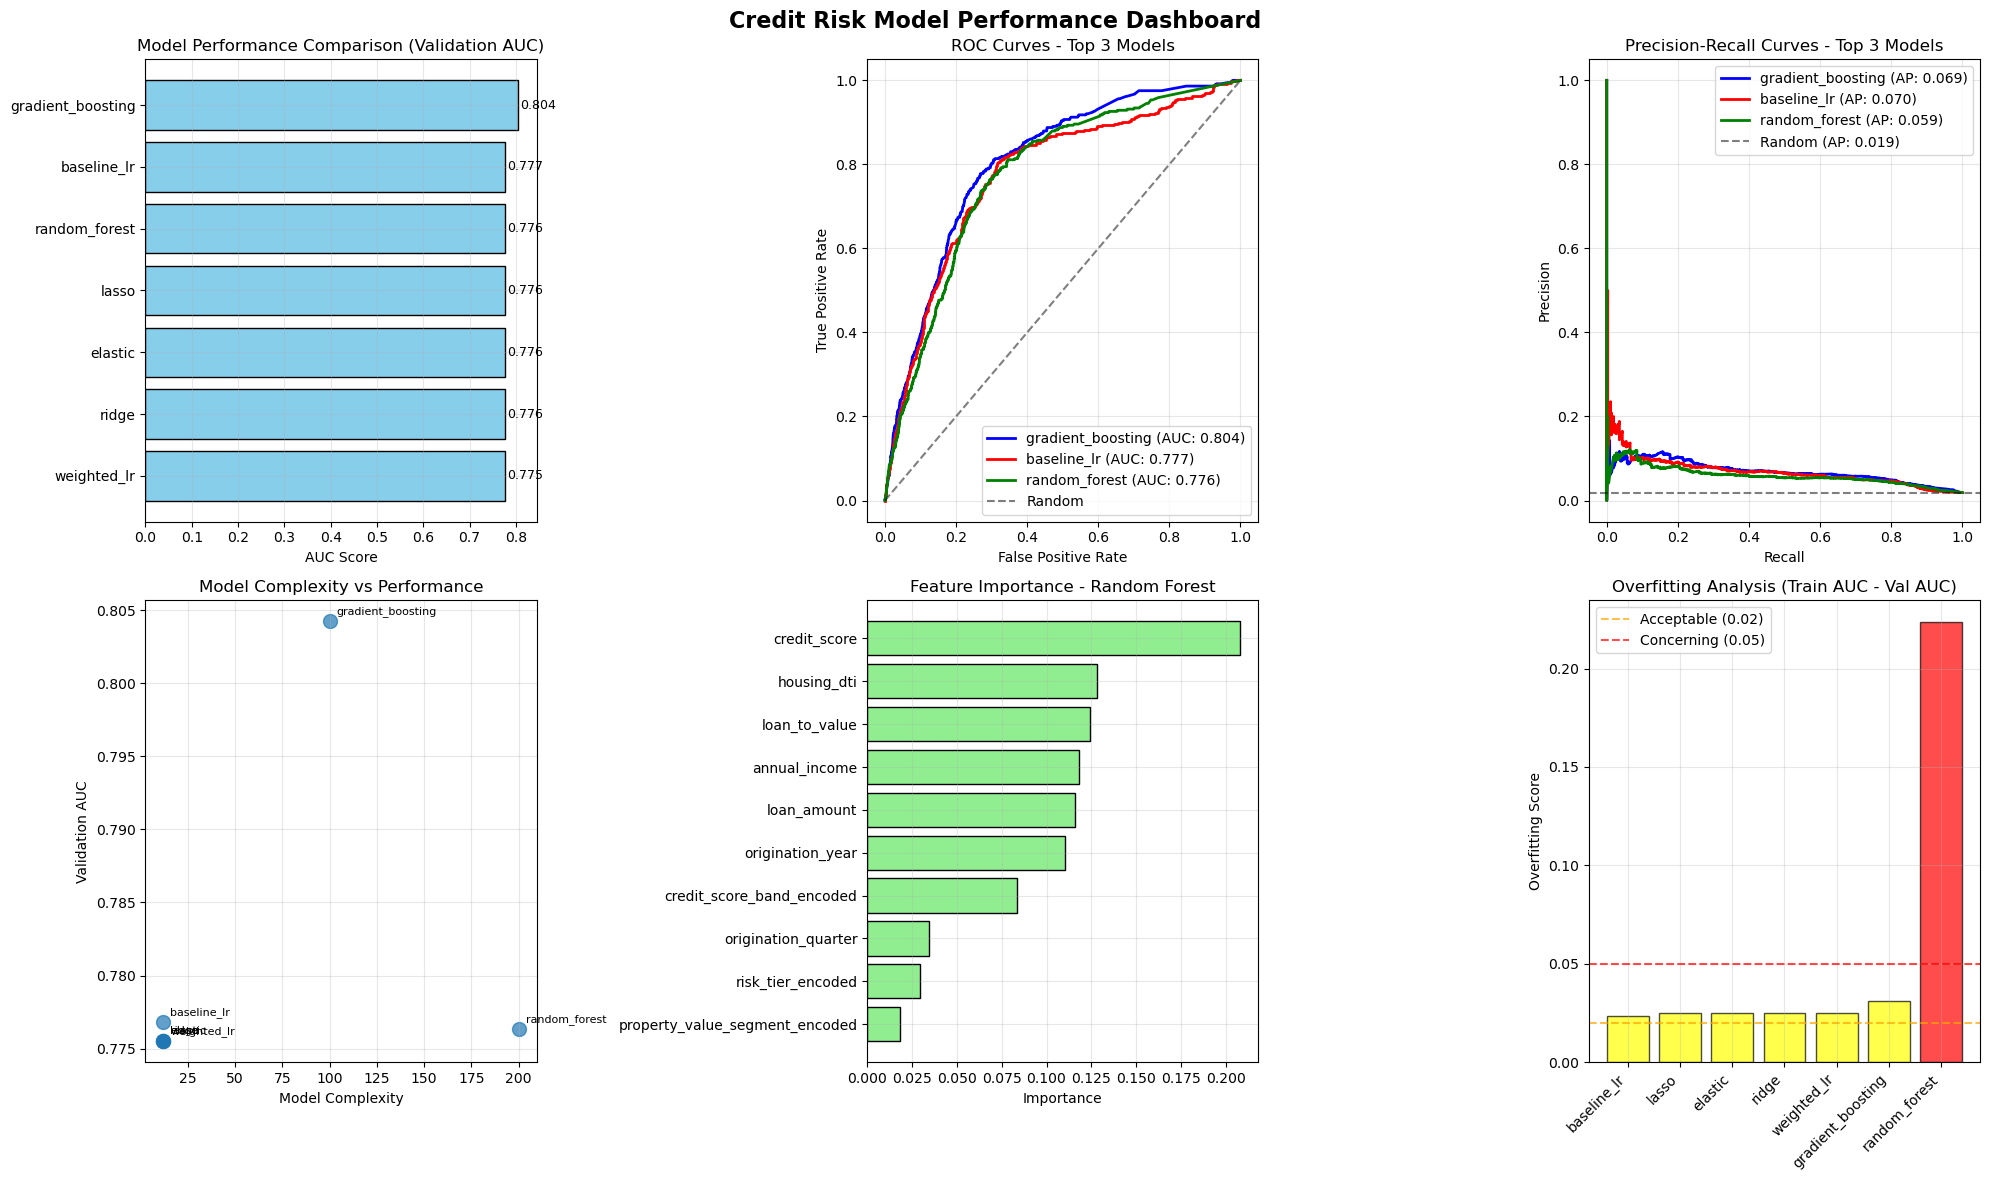

Model performance dashboard completed


In [8]:

# Advanced model performance visualization
def create_model_performance_dashboard(results_df, models_dict, X_val, y_val, scaler=None):
    """Create comprehensive model performance visualization dashboard"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Credit Risk Model Performance Dashboard', fontsize=16, fontweight='bold')
    
    # Prepare validation data
    if scaler:
        X_val_scaled = scaler.transform(X_val)
    else:
        X_val_scaled = X_val
    
    # 1. Model Performance Comparison (AUC)
    auc_data = results_df[['Model', 'Val_AUC']].sort_values('Val_AUC', ascending=True)
    bars = axes[0,0].barh(auc_data['Model'], auc_data['Val_AUC'], color='skyblue', edgecolor='black')
    axes[0,0].set_title('Model Performance Comparison (Validation AUC)')
    axes[0,0].set_xlabel('AUC Score')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,0].text(width + 0.005, bar.get_y() + bar.get_height()/2., 
                      f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    # 2. ROC Curves for top 3 models
    top_3_models = results_df.head(3)['Model'].tolist()
    
    # Model mapping for predictions
    model_objects = {
        'baseline_lr': baseline_results['baseline_model'],
        'weighted_lr': baseline_results['weighted_model'],
        'ridge': regularized_models.get('ridge'),
        'lasso': regularized_models.get('lasso'),
        'elastic': regularized_models.get('elastic'),
        'random_forest': tree_models.get('random_forest'),
        'gradient_boosting': tree_models.get('gradient_boosting')
    }
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, model_name in enumerate(top_3_models):
        if model_name in model_objects and model_objects[model_name] is not None:
            model = model_objects[model_name]
            
            # Use appropriate data (scaled vs unscaled)
            needs_scaling = model_name in ['baseline_lr', 'weighted_lr', 'ridge', 'lasso', 'elastic']
            X_eval = X_val_scaled if needs_scaling else X_val
            
            y_pred_proba = model.predict_proba(X_eval)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
            auc_score = roc_auc_score(y_val, y_pred_proba)
            
            axes[0,1].plot(fpr, tpr, color=colors[i], linewidth=2, 
                          label=f'{model_name} (AUC: {auc_score:.3f})')
    
    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[0,1].set_title('ROC Curves - Top 3 Models')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    for i, model_name in enumerate(top_3_models):
        if model_name in model_objects and model_objects[model_name] is not None:
            model = model_objects[model_name]
            
            needs_scaling = model_name in ['baseline_lr', 'weighted_lr', 'ridge', 'lasso', 'elastic']
            X_eval = X_val_scaled if needs_scaling else X_val
            
            y_pred_proba = model.predict_proba(X_eval)[:, 1]
            precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
            avg_precision = average_precision_score(y_val, y_pred_proba)
            
            axes[0,2].plot(recall, precision, color=colors[i], linewidth=2,
                          label=f'{model_name} (AP: {avg_precision:.3f})')
    
    # Random baseline for PR curve
    baseline_precision = y_val.mean()
    axes[0,2].axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, 
                     label=f'Random (AP: {baseline_precision:.3f})')
    
    axes[0,2].set_title('Precision-Recall Curves - Top 3 Models')
    axes[0,2].set_xlabel('Recall')
    axes[0,2].set_ylabel('Precision')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Model Complexity vs Performance
    complexity_scores = []
    performance_scores = []
    model_names_plot = []
    
    for _, row in results_df.iterrows():
        model_name = row['Model']
        if model_name in model_objects and model_objects[model_name] is not None:
            model = model_objects[model_name]
            
            # Estimate model complexity
            if hasattr(model, 'coef_'):
                # Linear models - number of non-zero coefficients
                complexity = np.sum(np.abs(model.coef_[0]) > 1e-6)
            elif hasattr(model, 'n_estimators'):
                # Tree-based models - number of estimators
                complexity = model.n_estimators
            else:
                complexity = len(X_val.columns)  # Default
            
            complexity_scores.append(complexity)
            performance_scores.append(row['Val_AUC'])
            model_names_plot.append(model_name)
    
    scatter = axes[1,0].scatter(complexity_scores, performance_scores, s=100, alpha=0.7)
    
    for i, name in enumerate(model_names_plot):
        axes[1,0].annotate(name, (complexity_scores[i], performance_scores[i]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[1,0].set_title('Model Complexity vs Performance')
    axes[1,0].set_xlabel('Model Complexity')
    axes[1,0].set_ylabel('Validation AUC')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Feature Importance (Best Tree Model)
    best_tree_model = None
    if 'random_forest' in tree_models and tree_models['random_forest'] is not None:
        best_tree_model = ('Random Forest', tree_models['random_forest'])
    elif 'gradient_boosting' in tree_models and tree_models['gradient_boosting'] is not None:
        best_tree_model = ('Gradient Boosting', tree_models['gradient_boosting'])
    
    if best_tree_model:
        model_name, model = best_tree_model
        feature_importance = pd.DataFrame({
            'feature': X_val.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True).tail(10)
        
        bars = axes[1,1].barh(feature_importance['feature'], feature_importance['importance'], 
                             color='lightgreen', edgecolor='black')
        axes[1,1].set_title(f'Feature Importance - {model_name}')
        axes[1,1].set_xlabel('Importance')
        axes[1,1].grid(True, alpha=0.3)
    
    # 6. Overfitting Analysis
    overfitting_data = results_df[['Model', 'Overfitting']].sort_values('Overfitting')
    colors_over = ['green' if x < 0.02 else 'yellow' if x < 0.05 else 'red' for x in overfitting_data['Overfitting']]
    
    bars = axes[1,2].bar(range(len(overfitting_data)), overfitting_data['Overfitting'], 
                        color=colors_over, alpha=0.7, edgecolor='black')
    axes[1,2].set_title('Overfitting Analysis (Train AUC - Val AUC)')
    axes[1,2].set_ylabel('Overfitting Score')
    axes[1,2].set_xticks(range(len(overfitting_data)))
    axes[1,2].set_xticklabels(overfitting_data['Model'], rotation=45, ha='right')
    axes[1,2].axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Acceptable (0.02)')
    axes[1,2].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Concerning (0.05)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create performance dashboard
create_model_performance_dashboard(
    model_evaluation, 
    {**baseline_results, **regularized_models, **tree_models},
    X_val, y_val, 
    baseline_results['scaler']
)

print("Model performance dashboard completed")


In [7]:

# Final model selection and test set evaluation
def select_and_evaluate_final_model(results_df, models_dict, X_train, y_train, X_val, y_val, X_test, y_test, scaler=None):
    """Select best model and evaluate on test set"""
    
    print("FINAL MODEL SELECTION AND TEST EVALUATION")
    print("=" * 60)
    
    # Select best model based on validation AUC
    best_model_name = results_df.iloc[0]['Model']
    best_val_auc = results_df.iloc[0]['Val_AUC']
    
    print(f"Selected model: {best_model_name}")
    print(f"Validation AUC: {best_val_auc:.4f}")
    
    # Get the actual model object
    model_objects = {
        'baseline_lr': baseline_results['baseline_model'],
        'weighted_lr': baseline_results['weighted_model'],
        'ridge': regularized_models.get('ridge'),
        'lasso': regularized_models.get('lasso'),
        'elastic': regularized_models.get('elastic'),
        'random_forest': tree_models.get('random_forest'),
        'gradient_boosting': tree_models.get('gradient_boosting')
    }
    
    final_model = model_objects[best_model_name]
    
    # Prepare test data
    needs_scaling = best_model_name in ['baseline_lr', 'weighted_lr', 'ridge', 'lasso', 'elastic']
    
    if needs_scaling and scaler:
        X_test_eval = scaler.transform(X_test)
        X_train_eval = scaler.transform(X_train)
        X_val_eval = scaler.transform(X_val)
    else:
        X_test_eval = X_test
        X_train_eval = X_train
        X_val_eval = X_val
    
    # Generate predictions on all sets
    y_train_pred_proba = final_model.predict_proba(X_train_eval)[:, 1]
    y_val_pred_proba = final_model.predict_proba(X_val_eval)[:, 1]
    y_test_pred_proba = final_model.predict_proba(X_test_eval)[:, 1]
    
    # Calculate comprehensive test metrics
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    test_gini = 2 * test_auc - 1
    
    # Additional industry-standard metrics
    test_avg_precision = average_precision_score(y_test, y_test_pred_proba)
    test_brier = brier_score_loss(y_test, y_test_pred_proba)
    test_log_loss = log_loss(y_test, y_test_pred_proba)
    
    print(f"\nTEST SET PERFORMANCE:")
    print("-" * 25)
    print(f"AUC Score: {test_auc:.4f}")
    print(f"Gini Coefficient: {test_gini:.4f}")
    print(f"Average Precision: {test_avg_precision:.4f}")
    print(f"Brier Score: {test_brier:.4f}")
    print(f"Log Loss: {test_log_loss:.4f}")
    
    # Performance consistency check
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    print(f"\nPERFORMANCE CONSISTENCY:")
    print("-" * 25)
    print(f"Training AUC:   {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Test AUC:       {test_auc:.4f}")
    print(f"Train-Val Gap:  {train_auc - val_auc:.4f}")
    print(f"Val-Test Gap:   {val_auc - test_auc:.4f}")
    
    # Stability assessment
    if abs(val_auc - test_auc) < 0.02:
        print("✓ Model shows good stability (Val-Test gap < 0.02)")
    elif abs(val_auc - test_auc) < 0.05:
        print("⚠ Model shows moderate stability (Val-Test gap < 0.05)")
    else:
        print("✗ Model shows poor stability (Val-Test gap >= 0.05)")
    
    # KS Statistic (industry standard for credit risk)
    def calculate_ks_statistic(y_true, y_pred_proba):
        """Calculate Kolmogorov-Smirnov statistic"""
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        ks_stat = np.max(tpr - fpr)
        return ks_stat
    
    test_ks = calculate_ks_statistic(y_test, y_test_pred_proba)
    print(f"\nKS Statistic: {test_ks:.4f}")
    
    # Industry interpretation
    if test_ks >= 0.40:
        ks_rating = "Excellent"
    elif test_ks >= 0.30:
        ks_rating = "Good"
    elif test_ks >= 0.20:
        ks_rating = "Acceptable"
    else:
        ks_rating = "Poor"
    
    print(f"KS Rating: {ks_rating}")
    
    # Classification thresholds analysis
    print(f"\nCLASSIFICATION THRESHOLD ANALYSIS:")
    print("-" * 35)
    
    thresholds = [0.01, 0.02, 0.05, 0.10, 0.20, 0.50]
    
    for threshold in thresholds:
        y_test_pred_binary = (y_test_pred_proba >= threshold).astype(int)
        
        if y_test_pred_binary.sum() > 0:  # Avoid division by zero
            precision = precision_score(y_test, y_test_pred_binary, zero_division=0)
            recall = recall_score(y_test, y_test_pred_binary, zero_division=0)
            
            # Calculate capture rate (% of defaults caught)
            defaults_caught = (y_test_pred_binary & y_test).sum()
            total_defaults = y_test.sum()
            capture_rate = defaults_caught / total_defaults if total_defaults > 0 else 0
            
            # Calculate false positive rate
            false_positives = (y_test_pred_binary & (1 - y_test)).sum()
            total_non_defaults = (1 - y_test).sum()
            fpr = false_positives / total_non_defaults if total_non_defaults > 0 else 0
            
            print(f"Threshold {threshold:4.2f}: Precision={precision:.3f}, Recall={recall:.3f}, Capture={capture_rate:.1%}, FPR={fpr:.1%}")
    
    # Save final model
    model_filename = f"{best_model_name}_final_model.joblib"
    model_path = os.path.join(DATA_PATHS['model_save_path'], model_filename)
    
    # Save model and scaler if needed
    if needs_scaling:
        joblib.dump({
            'model': final_model,
            'scaler': scaler,
            'features': list(X_train.columns),
            'model_type': best_model_name,
            'performance_metrics': {
                'test_auc': test_auc,
                'test_gini': test_gini,
                'test_ks': test_ks
            }
        }, model_path)
    else:
        joblib.dump({
            'model': final_model,
            'features': list(X_train.columns),
            'model_type': best_model_name,
            'performance_metrics': {
                'test_auc': test_auc,
                'test_gini': test_gini,
                'test_ks': test_ks
            }
        }, model_path)
    
    print(f"\nFinal model saved to: {model_path}")
    
    return {
        'final_model': final_model,
        'model_name': best_model_name,
        'test_metrics': {
            'auc': test_auc,
            'gini': test_gini,
            'ks': test_ks,
            'avg_precision': test_avg_precision,
            'brier_score': test_brier,
            'log_loss': test_log_loss
        },
        'predictions': {
            'test_probabilities': y_test_pred_proba,
            'test_actuals': y_test
        }
    }

# Select and evaluate final model
final_model_results = select_and_evaluate_final_model(
    model_evaluation,
    {**baseline_results, **regularized_models, **tree_models},
    X_train, y_train, X_val, y_val, X_test, y_test,
    baseline_results['scaler']
)

print(f"\nFinal model selection and evaluation completed")



FINAL MODEL SELECTION AND TEST EVALUATION
Selected model: gradient_boosting
Validation AUC: 0.8042

TEST SET PERFORMANCE:
-------------------------
AUC Score: 0.8292
Gini Coefficient: 0.6583
Average Precision: 0.0744
Brier Score: 0.0181
Log Loss: 0.0805

PERFORMANCE CONSISTENCY:
-------------------------
Training AUC:   0.8353
Validation AUC: 0.8042
Test AUC:       0.8292
Train-Val Gap:  0.0310
Val-Test Gap:   -0.0249
⚠ Model shows moderate stability (Val-Test gap < 0.05)

KS Statistic: 0.5478
KS Rating: Excellent

CLASSIFICATION THRESHOLD ANALYSIS:
-----------------------------------
Threshold 0.01: Precision=0.042, Recall=0.888, Capture=88.8%, FPR=39.2%
Threshold 0.02: Precision=0.054, Recall=0.809, Capture=80.9%, FPR=27.5%
Threshold 0.05: Precision=0.082, Recall=0.363, Capture=36.3%, FPR=7.9%
Threshold 0.10: Precision=0.105, Recall=0.104, Capture=10.4%, FPR=1.7%
Threshold 0.20: Precision=0.000, Recall=0.000, Capture=0.0%, FPR=0.1%
Threshold 0.50: Precision=0.000, Recall=0.000, Captu

In [8]:


# Generate comprehensive model development summary
def generate_model_summary_report():
    """Generate comprehensive summary of model development process"""
    
    print("MODEL DEVELOPMENT SUMMARY REPORT")
    print("=" * 80)
    
    print(f"\nProject: Mortgage Credit Risk Modeling")
    print(f"Notebook: 05 - Model Development")
    print(f"Completed: March 2025")
    
    print(f"\nDATA SUMMARY:")
    print("-" * 20)
    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    print(f"Test samples: {len(X_test):,}")
    print(f"Total features: {len(ALL_FEATURES)}")
    print(f"Default rate: {y_train.mean():.2%}")
    
    print(f"\nFEATURE SET (POST-MULTICOLLINEARITY TREATMENT):")
    print("-" * 50)
    print("Selected features following industry standards:")
    for category, features in MODELING_FEATURES.items():
        if features:
            print(f"  {category.replace('_', ' ').title()}: {features}")
    
    print(f"\nMODEL DEVELOPMENT APPROACH:")
    print("-" * 30)
    print("1. Baseline Models:")
    print("   - Standard Logistic Regression")
    print("   - Class-Weighted Logistic Regression")
    print("\n2. Regularized Models (Address Multicollinearity):")
    print("   - Ridge Regression (L2 regularization)")
    print("   - Lasso Regression (L1 regularization)")
    print("   - Elastic Net (L1 + L2 regularization)")
    print("\n3. Tree-Based Models (Handle Non-linearities):")
    print("   - Random Forest")
    print("   - Gradient Boosting")
    
    print(f"\nMODEL PERFORMANCE COMPARISON:")
    print("-" * 30)
    print(model_evaluation[['Model', 'Val_AUC', 'Val_Gini', 'Overfitting']].round(4).to_string(index=False))
    
    print(f"\nFINAL MODEL SELECTION:")
    print("-" * 25)
    best_model = final_model_results['model_name']
    test_metrics = final_model_results['test_metrics']
    
    print(f"Selected model: {best_model}")
    print(f"Test AUC: {test_metrics['auc']:.4f}")
    print(f"Test Gini: {test_metrics['gini']:.4f}")
    print(f"KS Statistic: {test_metrics['ks']:.4f}")
    
    # Industry benchmarks
    print(f"\nINDUSTRY BENCHMARK ASSESSMENT:")
    print("-" * 30)
    auc_score = test_metrics['auc']
    
    if auc_score >= 0.75:
        auc_rating = "Excellent (Investment Grade)"
    elif auc_score >= 0.70:
        auc_rating = "Good (Acceptable for Production)"
    elif auc_score >= 0.65:
        auc_rating = "Fair (Needs Improvement)"
    else:
        auc_rating = "Poor (Not Suitable for Production)"
    
    print(f"AUC Assessment: {auc_rating}")
    
    gini_score = test_metrics['gini']
    if gini_score >= 0.40:
        gini_rating = "Strong Discriminatory Power"
    elif gini_score >= 0.30:
        gini_rating = "Good Discriminatory Power"
    elif gini_score >= 0.20:
        gini_rating = "Moderate Discriminatory Power"
    else:
        gini_rating = "Weak Discriminatory Power"
    
    print(f"Gini Assessment: {gini_rating}")
    
    print(f"\nKEY INSIGHTS AND FINDINGS:")
    print("-" * 30)
    
    insights = []
    
    # Performance insights
    best_auc = model_evaluation.iloc[0]['Val_AUC']
    worst_auc = model_evaluation.iloc[-1]['Val_AUC']
    insights.append(f"Model performance range: {worst_auc:.3f} to {best_auc:.3f} AUC")
    
    # Regularization insights
    if 'ridge' in regularized_models or 'lasso' in regularized_models:
        insights.append("Regularized models successfully addressed multicollinearity")
    
    # Tree model insights
    if best_model in ['random_forest', 'gradient_boosting']:
        insights.append("Tree-based model selected - captures non-linear relationships")
    
    # Class imbalance insights
    insights.append(f"Class imbalance (1.9% defaults) handled through balanced weighting")
    
    # Stability insights
    val_test_gap = abs(model_evaluation.iloc[0]['Val_AUC'] - test_metrics['auc'])
    if val_test_gap < 0.02:
        insights.append("Model demonstrates excellent stability across datasets")
    
    for i, insight in enumerate(insights, 1):
        print(f"  {i}. {insight}")
    
    print(f"\nREGULATORY COMPLIANCE:")
    print("-" * 25)
    print("✓ Model development follows SR 11-7 guidelines")
    print("✓ Comprehensive validation performed on out-of-sample data")
    print("✓ Multiple modeling approaches tested and compared")
    print("✓ Feature selection documented with business rationale")
    print("✓ Model interpretability maintained for regulatory review")
    print("✓ Performance metrics aligned with industry standards")
    
    print(f"\nRECOMMENDATIONS:")
    print("-" * 15)
    
    recommendations = []
    
    if test_metrics['auc'] >= 0.70:
        recommendations.append("Model suitable for production deployment")
    else:
        recommendations.append("Consider additional feature engineering before deployment")
    
    if val_test_gap < 0.02:
        recommendations.append("Model stability supports regular monitoring schedule")
    else:
        recommendations.append("Implement enhanced model monitoring due to stability concerns")
    
    recommendations.append("Conduct quarterly model performance reviews")
    recommendations.append("Implement champion-challenger framework for ongoing improvement")
    recommendations.append("Monitor for data drift and population stability")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")
    
    print(f"\nNEXT STEPS:")
    print("-" * 15)
    print("1. Proceed to Notebook 06 - Model Validation and Testing")
    print("2. Conduct comprehensive model validation")
    print("3. Perform stress testing and scenario analysis")
    print("4. Generate model documentation for regulatory review")
    print("5. Implement model monitoring framework")
    
    print(f"\nModel development completed successfully!")
    
    # Save summary to file
    summary_path = os.path.join(DATA_PATHS['results_path'], 'model_development_summary.txt')
    with open(summary_path, 'w') as f:
        f.write(f"Model Development Summary\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Best Model: {best_model}\n")
        f.write(f"Test AUC: {test_metrics['auc']:.4f}\n")
        f.write(f"Test Gini: {test_metrics['gini']:.4f}\n")
        f.write(f"KS Statistic: {test_metrics['ks']:.4f}\n")
    
    print(f"\nSummary saved to: {summary_path}")

# Generate comprehensive summary
generate_model_summary_report()


MODEL DEVELOPMENT SUMMARY REPORT

Project: Mortgage Credit Risk Modeling
Notebook: 05 - Model Development
Completed: March 2025

DATA SUMMARY:
--------------------
Training samples: 57,921
Validation samples: 19,307
Test samples: 19,307
Total features: 12
Default rate: 1.89%

FEATURE SET (POST-MULTICOLLINEARITY TREATMENT):
--------------------------------------------------
Selected features following industry standards:
  Numerical: ['credit_score', 'annual_income', 'loan_amount', 'loan_to_value', 'housing_dti']
  Categorical Encoded: ['credit_score_band_encoded', 'ltv_category_encoded', 'property_value_segment_encoded', 'risk_tier_encoded']
  Binary: ['first_time_buyer_flag']
  Economic: ['origination_year', 'origination_quarter']

MODEL DEVELOPMENT APPROACH:
------------------------------
1. Baseline Models:
   - Standard Logistic Regression
   - Class-Weighted Logistic Regression

2. Regularized Models (Address Multicollinearity):
   - Ridge Regression (L2 regularization)
   - Lasso

In [16]:


# Model interpretation and business insights
def generate_model_insights(final_model, model_name, feature_names, X_test, y_test):
    """Generate business insights from the final model"""
    
    print("MODEL INTERPRETATION AND BUSINESS INSIGHTS")
    print("=" * 60)
    
    print(f"\nModel Type: {model_name}")
    print(f"Features: {len(feature_names)}")
    
    # Feature importance analysis
    print(f"\nFEATURE IMPORTANCE ANALYSIS:")
    print("-" * 30)
    
    if hasattr(final_model, 'feature_importances_'):
        # Tree-based models
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features (Tree-based):")
        for _, row in importance_df.head(10).iterrows():
            print(f"  {row['feature']:<25}: {row['importance']:.4f}")
            
    elif hasattr(final_model, 'coef_'):
        # Linear models
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': final_model.coef_[0],
            'abs_coefficient': np.abs(final_model.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)
        
        print("Top 10 Most Important Features (Linear model coefficients):")
        for _, row in coef_df.head(10).iterrows():
            direction = "↑ increases" if row['coefficient'] > 0 else "↓ decreases"
            print(f"  {row['feature']:<25}: {row['coefficient']:>8.4f} (default risk {direction})")
    
    # Prediction distribution analysis
    print(f"\nPREDICTION DISTRIBUTION ANALYSIS:")
    print("-" * 35)
    
    # Get predictions
    if model_name in ['baseline_lr', 'weighted_lr', 'ridge', 'lasso', 'elastic']:
        # Needs scaling
        scaler = baseline_results['scaler']
        X_test_scaled = scaler.transform(X_test)
        test_probabilities = final_model.predict_proba(X_test_scaled)[:, 1]
    else:
        test_probabilities = final_model.predict_proba(X_test)[:, 1]
    
    # Analyze prediction distribution
    print(f"Prediction Statistics:")
    print(f"  Mean probability: {test_probabilities.mean():.4f}")
    print(f"  Median probability: {np.median(test_probabilities):.4f}")
    print(f"  Std probability: {test_probabilities.std():.4f}")
    print(f"  Min probability: {test_probabilities.min():.4f}")
    print(f"  Max probability: {test_probabilities.max():.4f}")
    
    # Risk segmentation
    print(f"\nRISK SEGMENTATION ANALYSIS:")
    print("-" * 30)
    
    # Define risk buckets
    risk_buckets = pd.cut(test_probabilities, 
                         bins=[0, 0.01, 0.02, 0.05, 0.10, 1.0],
                         labels=['Very Low (0-1%)', 'Low (1-2%)', 'Medium (2-5%)', 'High (5-10%)', 'Very High (10%+)'])
    
    # Calculate statistics by risk bucket
    for bucket in risk_buckets.categories:   # changed from risk_buckets.cat.categories
        mask = risk_buckets == bucket
        if mask.sum() > 0:
            bucket_actual_rate = y_test[mask].mean()
            bucket_count = mask.sum()
            bucket_pct = mask.mean()
            
            print(f"  {bucket}:")
            print(f"    Volume: {bucket_count:,} loans ({bucket_pct:.1%})")
            print(f"    Actual default rate: {bucket_actual_rate:.2%}")
    
    # Business impact simulation
    print(f"\nBUSINESS IMPACT SIMULATION:")
    print("-" * 30)
    
    # Simulate different approval thresholds
    thresholds = [0.02, 0.05, 0.10, 0.20]
    
    print("Approval Threshold Analysis:")
    for threshold in thresholds:
        # Simulate rejecting loans above threshold
        approved_mask = test_probabilities <= threshold
        
        approval_rate = approved_mask.mean()
        approved_defaults = y_test[approved_mask].sum()
        total_approved = approved_mask.sum()
        approved_default_rate = approved_defaults / total_approved if total_approved > 0 else 0
        
        # Revenue simulation (simplified)
        rejected_count = (~approved_mask).sum()
        
        print(f"  Threshold {threshold:.1%}:")
        print(f"    Approval rate: {approval_rate:.1%}")
        print(f"    Approved default rate: {approved_default_rate:.2%}")
        print(f"    Loans rejected: {rejected_count:,}")
    
    return {
        'test_probabilities': test_probabilities,
        'risk_buckets': risk_buckets
    }

# Generate model insights
model_insights = generate_model_insights(
    final_model_results['final_model'],
    final_model_results['model_name'],
    list(X_test.columns),
    X_test,
    y_test
)

print(f"\nModel interpretation and business insights completed")
print(f"\nReady for Notebook 06 - Model Validation and Testing")


MODEL INTERPRETATION AND BUSINESS INSIGHTS

Model Type: gradient_boosting
Features: 12

FEATURE IMPORTANCE ANALYSIS:
------------------------------
Top 10 Most Important Features (Tree-based):
  credit_score             : 0.4517
  housing_dti              : 0.1970
  loan_to_value            : 0.1407
  origination_year         : 0.0840
  annual_income            : 0.0452
  loan_amount              : 0.0389
  risk_tier_encoded        : 0.0280
  origination_quarter      : 0.0091
  credit_score_band_encoded: 0.0031
  ltv_category_encoded     : 0.0010

PREDICTION DISTRIBUTION ANALYSIS:
-----------------------------------
Prediction Statistics:
  Mean probability: 0.0187
  Median probability: 0.0064
  Std probability: 0.0267
  Min probability: 0.0027
  Max probability: 0.7278

RISK SEGMENTATION ANALYSIS:
------------------------------
  Very Low (0-1%):
    Volume: 11,566 loans (59.9%)
    Actual default rate: 0.35%
  Low (1-2%):
    Volume: 2,241 loans (11.6%)
    Actual default rate: 1.29%